In [328]:
import io
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import cmasher as cmr

import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import (
    SkyCoord,
    EarthLocation,
    AltAz,
    get_body,
    solar_system_ephemeris,
)

In [329]:
SKYCAM_URL = "https://aat-ops.anu.edu.au/skycam/telescope/telescope.jpg"

# --- Observatory coordinates live here (easy to add more) ---
OBSERVATORIES = {
    # Siding Spring Observatory (AAT)
    "AAT": {"lat_deg": -31.2733, "lon_deg": 149.0661, "height_m": 1165},
}
DEFAULT_OBSERVATORY = "AAT"

In [330]:
RADIO_GAGA = "AAT_Veloce_Nightslogs_24A_24B_25A_25B_01 - RadioGaGa.csv"
TWINS_05 = "AAT_Veloce_Nightslogs_24A_24B_25A_25B_01 - StellarTwins_MH_-0.5_fixed.csv"
TWINS_08 = "AAT_Veloce_Nightslogs_24A_24B_25A_25B_01 - StellarTwins_MH_-0.8_fixed.csv"

In [ ]:
import pandas as pd

# --- Only input you should need to change ---
CSV_FILE = TWINS_08
# ------------------------------------------

df = pd.read_csv(CSV_FILE)
# Normalize column names (some CSV exports include trailing spaces)
df.columns = df.columns.astype(str).str.strip()



df = df[df["CCD1"].astype(float) < 100]


df.head()

,Object_ID,RA,Dec,BP,RP,2,15,Details GSPPhot,teff_gspspec,logg_gspspec,mh_gspspec,Date,ExtraDate,CCD1,CCD2,CCD3,Unnamed: 20
0,5000840365029995776,0:48:4.42,-37:29:48.51,9.6,8.5,0,1,NaN,4717,2.27,-0.77,251105.0,251106,53.0,167.0,433.0,2nd exposure 251106 1500s
3,4960668814357088256,1:39:9.09,-39:25:59.48,9.7,8.6,0,1,NaN,4848,2.33,-0.76,251109.0,NaN,47.0,145.0,341.0,NaN
11,5104540013930244864,3:14:4.22,-17:51:58.42,8.8,7.7,0,1,NaN,4965,2.50,-0.83,251107.0,NaN,44.0,152.0,357.0,NaN
35,5508551060433327488,7:7:55.65,-48:55:1.49,9.1,8.0,0,1,NaN,4978,2.38,-0.81,251109.0,NaN,75.0,219.0,544.0,NaN
45,5598559212594993152,7:46:27.6,-30:58:7.99,10.2,9.1,0,1,NaN,4885,2.11,-0.77,251101.0,"251102, 260104",34.0,135.0,333.0,NaN


In [332]:
%matplotlib widget

In [333]:
def fetch_skycam():
    r = requests.get(SKYCAM_URL, timeout=10)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")
    return np.asarray(img)

In [334]:
def calibrate_skycam(img, r_frac=0.48, detect_circle=False):
    """Calibrate the skycam *circle*.

    By default this uses a simple, stable crop: a circle centered in the image.
    That avoids the detector occasionally "jumping" when the live image changes.

    Parameters
    ----------
    r_frac : float
        Radius as a fraction of min(image_height, image_width)
    detect_circle : bool
        If True, attempt to detect the circle (Hough/contour) and fall back to the
        simple centered circle if detection fails.
    """
    h, w = img.shape[:2]

    # Simple, robust default
    cx = w / 2.0
    cy = h / 2.0
    r = float(r_frac) * float(min(h, w))

    if detect_circle:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (9, 9), 0)

        circles = cv2.HoughCircles(
            blur,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=min(h, w) / 3,
            param1=120,
            param2=35,
            minRadius=int(0.30 * min(h, w)),
            maxRadius=int(0.55 * min(h, w)),
        )

        det = None
        if circles is not None and len(circles) > 0:
            cands = np.asarray(circles[0], dtype=float)  # (x, y, r)
            img_center = np.array([w / 2.0, h / 2.0])
            d = np.linalg.norm(cands[:, :2] - img_center[None, :], axis=1)
            score = cands[:, 2] - 0.5 * d
            det = cands[np.argmax(score)]
        else:
            _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if cnts:
                cnt = max(cnts, key=cv2.contourArea)
                (dcx, dcy), dr = cv2.minEnclosingCircle(cnt)
                det = np.array([dcx, dcy, dr], dtype=float)

        # Validate detection; otherwise keep simple defaults
        if det is not None:
            dcx, dcy, dr = float(det[0]), float(det[1]), float(det[2])
            if (0 < dr < 0.6 * min(h, w)) and (0 <= dcx <= w) and (0 <= dcy <= h):
                cx, cy, r = dcx, dcy, dr

    # Detect north from red compass (best-effort)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    r1 = cv2.inRange(hsv, (0, 80, 80), (10, 255, 255))
    r2 = cv2.inRange(hsv, (170, 80, 80), (180, 255, 255))
    red = r1 | r2
    edges = cv2.Canny(red, 50, 150)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 120)
    north_angle = 0.0
    if lines is not None:
        north_angle = np.rad2deg(np.mean([l[0][1] for l in lines])) - 90.0

    return {
        "center": (cx, cy),
        "radius": r,
        "north_angle": north_angle,
    }


In [335]:
def build_circle_mask(shape, calib):
    h, w = shape[:2]
    cx, cy = calib["center"]
    r = calib["radius"]

    y, x = np.ogrid[:h, :w]
    return ((x - cx) ** 2 + (y - cy) ** 2) <= (r ** 2)


CROP_MARGIN = 1.00  # 1.00 keeps the circle edge at radius=1 in the plot

def crop_sky_circle(img, calib, mask, margin=CROP_MARGIN):
    cx, cy = calib["center"]
    r = calib["radius"]

    r_crop = int(r * margin)
    cx, cy = int(cx), int(cy)

    x0 = max(cx - r_crop, 0)
    x1 = min(cx + r_crop, img.shape[1])
    y0 = max(cy - r_crop, 0)
    y1 = min(cy + r_crop, img.shape[0])

    crop = img[y0:y1, x0:x1]
    crop_mask = mask[y0:y1, x0:x1]

    alpha = np.zeros(crop.shape[:2], dtype=np.uint8)
    alpha[crop_mask] = 255

    return np.dstack([crop, alpha])


In [336]:
import numpy as np

def airmass_kasten_young(alt_deg):
    """
    Compute airmass using Kasten & Young (1989).
    
    Parameters
    ----------
    alt_deg : array-like or float
        Altitude in degrees

    Returns
    -------
    airmass : array-like or float
    """
    alt = np.asarray(alt_deg, dtype=float)
    z = 90.0 - alt  # zenith angle in degrees

    # Avoid nonsense below horizon
    am = np.full_like(z, np.nan, dtype=float)
    valid = alt > 0

    am[valid] = 1.0 / (
        np.cos(np.deg2rad(z[valid])) +
        0.50572 * (96.07995 - z[valid])**(-1.6364)
    )

    return am


In [337]:
def _altaz_to_xy(alt_deg, az_deg, north_angle):
    """Project Alt/Az to the same unit-disk x/y used for the skycam overlay."""
    alt = np.asarray(alt_deg, dtype=float)
    az = np.asarray(az_deg, dtype=float)

    r = np.cos(np.deg2rad(alt))
    x = -r * np.sin(np.deg2rad(az))
    y =  r * np.cos(np.deg2rad(az))

    # Rotate to true north
    ang = np.deg2rad(-north_angle)
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)

    return xr, yr


def radec_to_xy(df, lat, lon, height, north_angle):
    loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=height*u.m)
    t = Time.now()

    ra  = np.asarray(df["RA_deg"], dtype=float)
    dec = np.asarray(df["Dec_deg"], dtype=float)

    sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    aa = sc.transform_to(AltAz(obstime=t, location=loc))

    alt = aa.alt.deg
    az  = aa.az.deg

    am = airmass_kasten_young(alt)

    mask = alt > 0
    row_idx = np.where(mask)[0]  # map plotted points back to df rows

    alt = alt[mask]
    az  = az[mask]
    am  = am[mask]

    xr, yr = _altaz_to_xy(alt, az, north_angle)

    # Pick a reasonable label column if present
    label_col = None
    for c in ("Object_ID", "Object", "Name", "Target", "ID"):
        if c in df.columns:
            label_col = c
            break
    labels = df.loc[mask, label_col].astype(str).values if label_col is not None else None

    return xr, yr, labels, alt, az, am, row_idx, t


SOLAR_SYSTEM_PLANETS = [
    "moon",
    "mercury",
    "venus",
    "mars",
    "jupiter",
    "saturn",
    "uranus",
    "neptune",
]


def planets_to_xy(lat, lon, height, north_angle, t=None, bodies=SOLAR_SYSTEM_PLANETS):
    """Compute visible planet positions (x/y) for the given observer location/time."""
    loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=height*u.m)
    if t is None:
        t = Time.now()

    xs, ys, labels, alts, azs, ams = [], [], [], [], [], []

    with solar_system_ephemeris.set("builtin"):
        for b in bodies:
            try:
                aa = get_body(b, t, loc).transform_to(AltAz(obstime=t, location=loc))
            except Exception:
                continue

            alt = float(aa.alt.deg)
            az = float(aa.az.deg)
            if not (alt > 0):
                continue

            am = float(airmass_kasten_young(alt))
            x, y = _altaz_to_xy(alt, az, north_angle)

            xs.append(float(np.asarray(x)))
            ys.append(float(np.asarray(y)))
            labels.append(str(b).title())
            alts.append(alt)
            azs.append(az)
            ams.append(am)

    return np.asarray(xs), np.asarray(ys), labels, np.asarray(alts), np.asarray(azs), np.asarray(ams)


In [338]:
df.head()

,Object_ID,RA,Dec,BP,RP,2,15,Details GSPPhot,teff_gspspec,logg_gspspec,mh_gspspec,Date,ExtraDate,CCD1,CCD2,CCD3,Unnamed: 20
0,5000840365029995776,0:48:4.42,-37:29:48.51,9.6,8.5,0,1,NaN,4717,2.27,-0.77,251105.0,251106,53.0,167.0,433.0,2nd exposure 251106 1500s
3,4960668814357088256,1:39:9.09,-39:25:59.48,9.7,8.6,0,1,NaN,4848,2.33,-0.76,251109.0,NaN,47.0,145.0,341.0,NaN
11,5104540013930244864,3:14:4.22,-17:51:58.42,8.8,7.7,0,1,NaN,4965,2.50,-0.83,251107.0,NaN,44.0,152.0,357.0,NaN
35,5508551060433327488,7:7:55.65,-48:55:1.49,9.1,8.0,0,1,NaN,4978,2.38,-0.81,251109.0,NaN,75.0,219.0,544.0,NaN
45,5598559212594993152,7:46:27.6,-30:58:7.99,10.2,9.1,0,1,NaN,4885,2.11,-0.77,251101.0,"251102, 260104",34.0,135.0,333.0,NaN


In [339]:
import numpy as np

def _hms_to_tuple(hms_str):
    parts = str(hms_str).strip().split(":")
    if len(parts) != 3:
        return None
    try:
        return tuple(float(p) for p in parts)
    except ValueError:
        return None


def parse_ra_to_deg(v):
    """Accepts RA as degrees, hours, or 'hh:mm:ss' string; returns degrees in [0, 360)."""
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return np.nan

    if isinstance(v, (int, float, np.integer, np.floating)):
        x = float(v)
        # Heuristic: small numbers are often hours
        if 0.0 <= x <= 24.0:
            return (15.0 * x) % 360.0
        return x % 360.0

    s = str(v).strip()
    if not s:
        return np.nan
    if ":" in s:
        t = _hms_to_tuple(s)
        if t is None:
            return np.nan
        h, m, sec = t
        return (15.0 * (h + m / 60.0 + sec / 3600.0)) % 360.0

    try:
        x = float(s)
        if 0.0 <= x <= 24.0:
            return (15.0 * x) % 360.0
        return x % 360.0
    except ValueError:
        return np.nan


def parse_dec_to_deg(v):
    """Accepts Dec as degrees or '+dd:mm:ss'/'-dd:mm:ss' string; returns degrees."""
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return np.nan

    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v)

    s = str(v).strip()
    if not s:
        return np.nan

    if ":" in s:
        sign = -1 if s.startswith("-") else 1
        t = _hms_to_tuple(s.lstrip("+-"))
        if t is None:
            return np.nan
        d, m, sec = t
        return sign * (abs(d) + m / 60.0 + sec / 3600.0)

    try:
        return float(s)
    except ValueError:
        return np.nan


def ensure_radec_deg(df, ra_col="RA", dec_col="Dec"):
    """Ensures df has RA_deg/Dec_deg columns (auto-parsed)."""
    if "RA_deg" not in df.columns:
        if ra_col not in df.columns:
            raise KeyError(f"Missing RA column: {ra_col!r} (or provide RA_deg)")
        df["RA_deg"] = df[ra_col].apply(parse_ra_to_deg)

    if "Dec_deg" not in df.columns:
        if dec_col not in df.columns:
            raise KeyError(f"Missing Dec column: {dec_col!r} (or provide Dec_deg)")
        df["Dec_deg"] = df[dec_col].apply(parse_dec_to_deg)

    return df


df = ensure_radec_deg(df)


In [340]:
def resolve_observatory(observatory=None, lat_deg=None, lon_deg=None, height_m=None):
    """Resolve site coordinates from a named observatory, with optional overrides."""
    if observatory is None:
        observatory = DEFAULT_OBSERVATORY

    if isinstance(observatory, str):
        if observatory not in OBSERVATORIES:
            raise KeyError(
                f"Unknown observatory {observatory!r}. Add it to OBSERVATORIES or pass lat/lon/height explicitly."
            )
        cfg = dict(OBSERVATORIES[observatory])
    elif isinstance(observatory, dict):
        cfg = dict(observatory)
    else:
        raise TypeError("observatory must be a name (str) or dict with lat_deg/lon_deg/height_m")

    if lat_deg is not None:
        cfg["lat_deg"] = lat_deg
    if lon_deg is not None:
        cfg["lon_deg"] = lon_deg
    if height_m is not None:
        cfg["height_m"] = height_m

    return cfg


def _plot_masked_polyline(ax, x, y, mask, **plot_kwargs):
    """Plot a polyline but only where mask is True, splitting at gaps."""
    idx = np.flatnonzero(mask)
    if idx.size == 0:
        return

    gaps = np.flatnonzero(np.diff(idx) > 1)
    starts = np.r_[0, gaps + 1]
    ends = np.r_[gaps, idx.size - 1]

    for s, e in zip(starts, ends):
        seg = idx[s : e + 1]
        if seg.size >= 2:
            ax.plot(x[seg], y[seg], **plot_kwargs)


def add_radec_grid(
    ax,
    *,
    lat_deg,
    lon_deg,
    height_m,
    north_angle,
    t,
    ra_step_deg=30,
    dec_step_deg=15,
    color="white",
    alpha=0.35,
    lw=0.8,
    label=True,
):
    """Overlay an equatorial (RA/Dec) grid projected onto the skycam unit disk."""
    loc = EarthLocation(lat=lat_deg * u.deg, lon=lon_deg * u.deg, height=height_m * u.m)

    # RA lines (constant RA, varying Dec)
    dec_samp = np.linspace(-85, 85, 721)
    for ra_deg in np.arange(0, 360, ra_step_deg, dtype=float):
        sc = SkyCoord(ra=np.full_like(dec_samp, ra_deg) * u.deg, dec=dec_samp * u.deg)
        aa = sc.transform_to(AltAz(obstime=t, location=loc))

        alt = aa.alt.deg
        az = aa.az.deg
        vis = alt > 0

        x, y = _altaz_to_xy(alt, az, north_angle)
        _plot_masked_polyline(ax, x, y, vis, color=color, alpha=alpha, lw=lw, zorder=1)

        if label and np.any(vis):
            i = int(np.nanargmax(np.where(vis, alt, np.nan)))
            rah = int(np.round(ra_deg / 15.0)) % 24
            ax.text(
                float(x[i]),
                float(y[i]),
                f"{rah}h",
                color=color,
                fontsize=7,
                ha="center",
                va="center",
                alpha=min(1.0, alpha + 0.25),
                zorder=1,
                bbox=dict(boxstyle="round,pad=0.15", fc="black", ec="none", alpha=0.35),
            )

    # Dec lines (constant Dec, varying RA)
    ra_samp = np.linspace(0, 360, 1000, endpoint=False)
    for dec_deg in np.arange(-75, 90, dec_step_deg, dtype=float):
        sc = SkyCoord(ra=ra_samp * u.deg, dec=np.full_like(ra_samp, dec_deg) * u.deg)
        aa = sc.transform_to(AltAz(obstime=t, location=loc))

        alt = aa.alt.deg
        az = aa.az.deg
        vis = alt > 0

        x, y = _altaz_to_xy(alt, az, north_angle)
        _plot_masked_polyline(ax, x, y, vis, color=color, alpha=alpha, lw=lw, zorder=1)

        if label and np.any(vis):
            i = int(np.nanargmax(np.where(vis, alt, np.nan)))
            ax.text(
                float(x[i]),
                float(y[i]),
                f"{dec_deg:+.0f}°",
                color=color,
                fontsize=7,
                ha="center",
                va="center",
                alpha=min(1.0, alpha + 0.25),
                zorder=1,
                bbox=dict(boxstyle="round,pad=0.15", fc="black", ec="none", alpha=0.35),
            )


def plot_static_skycam(
    df,
    observatory=DEFAULT_OBSERVATORY,
    figsize=(7, 7),
    *,
    lat_deg=None,
    lon_deg=None,
    height_m=None,
    show_radec_grid=True,
    ra_grid_step_deg=30,
    dec_grid_step_deg=15,
    show_background_image=True,
):
    # Make sure RA_deg/Dec_deg exist even if the CSV only has RA/Dec strings
    df = ensure_radec_deg(df)

    site = resolve_observatory(observatory, lat_deg=lat_deg, lon_deg=lon_deg, height_m=height_m)
    lat_deg = site["lat_deg"]
    lon_deg = site["lon_deg"]
    height_m = site["height_m"]

    img = fetch_skycam()
    calib = calibrate_skycam(img)
    mask = build_circle_mask(img.shape, calib)
    sky = crop_sky_circle(img, calib, mask)

    x, y, labels, alt, az, am, row_idx, t = radec_to_xy(
        df, lat_deg, lon_deg, height_m, calib["north_angle"]
    )

    if len(x) == 0:
        print("No targets above the horizon right now.")
        return

    fig, ax = plt.subplots(figsize=figsize)

    if show_background_image:
        ax.imshow(
            sky,
            extent=[-1, 1, -1, 1],
            origin="upper",
            zorder=0,
            interpolation="bilinear",
        )
    else:
        ax.set_facecolor("black")
        ax.add_patch(plt.Circle((0, 0), 1.0, color="black", zorder=0))

    if show_radec_grid:
        add_radec_grid(
            ax,
            lat_deg=lat_deg,
            lon_deg=lon_deg,
            height_m=height_m,
            north_angle=calib["north_angle"],
            t=t,
            ra_step_deg=ra_grid_step_deg,
            dec_step_deg=dec_grid_step_deg,
            color="white",
            alpha=0.35,
            lw=0.8,
            label=True,
        )

    # Small arrow showing sky drift direction (diurnal rotation) at this site/time
    try:
        loc = EarthLocation(lat=lat_deg * u.deg, lon=lon_deg * u.deg, height=height_m * u.m)
        dt = 10 * u.min

        # Build a fixed ICRS point from a convenient current Alt/Az (east @ mid-altitude)
        aa0 = SkyCoord(
            alt=45 * u.deg,
            az=90 * u.deg,
            frame=AltAz(obstime=t, location=loc),
        )
        icrs = aa0.icrs
        aa1 = icrs.transform_to(AltAz(obstime=t + dt, location=loc))

        x0, y0 = _altaz_to_xy(float(aa0.alt.deg), float(aa0.az.deg), calib["north_angle"])
        x1, y1 = _altaz_to_xy(float(aa1.alt.deg), float(aa1.az.deg), calib["north_angle"])

        dx = float(np.asarray(x1 - x0))
        dy = float(np.asarray(y1 - y0))
        norm = (dx * dx + dy * dy) ** 0.5
        if norm > 0:
            ux, uy = dx / norm, dy / norm
            start = (0.55, 0.78)
            L = 0.22
            ax.annotate(
                "",
                xy=(start[0] + ux * L, start[1] + uy * L),
                xytext=start,
                arrowprops=dict(arrowstyle="->", color="red", lw=2),
                zorder=4,
            )
            ax.text(
                start[0],
                start[1],
                "sky rotates",
                color="white",
                fontsize=9,
                ha="left",
                va="bottom",
                zorder=4,
            )
    except Exception as e:
        print("Error calculating sky drift direction: ", e)
        pass

    sc = ax.scatter(x, y, c=am, s=70, edgecolor="black", zorder=2, cmap="cmr.prinsenvlag")

    # Planets (distinct marker + color)
    px, py, plabels, palt, paz, pam = planets_to_xy(
        lat_deg, lon_deg, height_m, calib["north_angle"], t=t
    )
    scp = None
    if len(px) > 0:
        scp = ax.scatter(
            px,
            py,
            s=160,
            marker="*",
            c="#ff4fd8",
            edgecolor="white",
            linewidth=0.8,
            zorder=3,
        )

    cursor = mplcursors.cursor([a for a in (sc, scp) if a is not None], hover=True)

    @cursor.connect("add")
    def on_add(sel):
        i = sel.index

        if sel.artist is sc:
            name = labels[i] if labels is not None else f"Target {i}"
            # Pull CCD values from the original df row
            row = df.iloc[int(row_idx[i])]
            def _ccd_val(col):
                v = row[col] if col in row.index else np.nan
                try:
                    return float(v)
                except Exception:
                    return np.nan

            c1 = _ccd_val("CCD1")
            c2 = _ccd_val("CCD2")
            c3 = _ccd_val("CCD3")
            csum = np.nansum([c1, c2, c3])

            sel.annotation.set_text(
                f"{name}\n"
                f"Alt: {alt[i]:.1f}°\n"
                f"Az: {az[i]:.1f}°\n"
                f"Airmass: {am[i]:.2f}\n"
                f"CCD1: {c1:.0f}  CCD2: {c2:.0f}  CCD3: {c3:.0f}\n"
                f"CCD sum: {csum:.0f}"
            )
        else:
            name = plabels[i] if plabels is not None else f"Planet {i}"
            sel.annotation.set_text(
                f"{name}\n"
                f"Alt: {palt[i]:.1f}°\n"
                f"Az: {paz[i]:.1f}°\n"
                f"Airmass: {pam[i]:.2f}"
            )

        # Style annotation box + text (mplcursors-correct)
        sel.annotation.get_bbox_patch().set(fc="black", alpha=0.8)
        sel.annotation.set_color("white")

    # Add colorbar for airmass
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Airmass")

    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color="white", lw=1)

    ax.set_title(f"AAT Skycam — {t.iso[:-4]} UTC", fontsize=11)
    ax.set_aspect("equal")
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

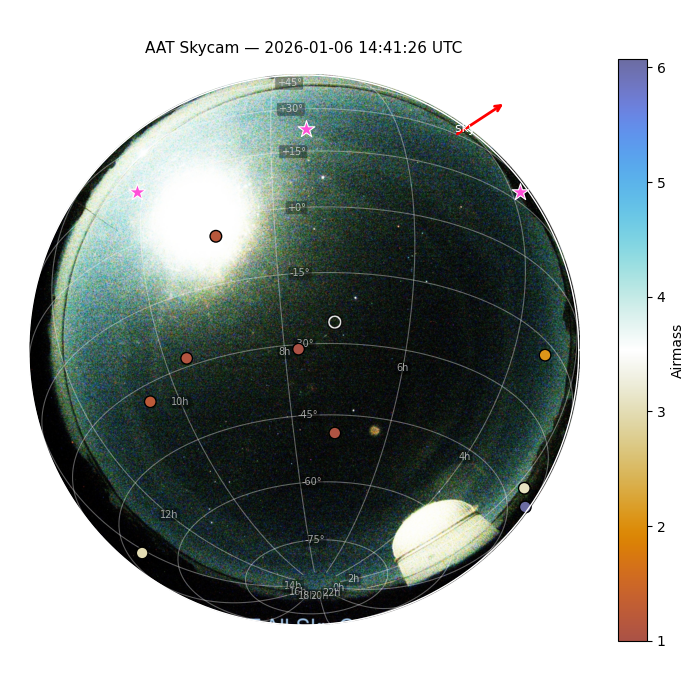

In [341]:
plot_static_skycam(df, show_background_image=True)